# Logistic regression
## Introduction
In this notebook we will classify data into binary classes based on continuous variables, using logistic regression. The data come from the *wine* data set included in the Python module Scikit-learn. We will first determine a linear decision boundary to classify two wines, then a non-linear decision boundary to discriminate a wine among the three included in the data set. The non-linear classification will allow us to use regularization of data and polynomial combination of features.

Numpy will be our workhorse for data structures and operations, while Matplotlib.pyplot and Seaborn will be used for data visualization. Finally, Scikit-learn will provide the data set and a function to split data into training and testing samples.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn import datasets
from sklearn.model_selection import train_test_split
import seaborn as sns
sns.set()

#load wine data
wine = datasets.load_wine()

## Definition of a logistic regression class
We will create a class called *LogisticRegression* containing the functions which will serve to perform logistic regression. The whole class must be defined at once, please read the comments and docstrings for explanations.

In [2]:
class LogisticRegression(object):
    """This class provides methods to perform logistic regression on data.
alpha          : learning rate, default to 0.001
n_iter         : number of iteration of gradient descent, default to 10000
regularization : set to True if input should be regularized to avoid overfitting, default to False
lamb           : lambda parameter for regularization, default to 1
intercept      : set to True to add a column of ones to the input data, default to True
norm           : set to True to normalize data, default to False
map_feat       : set to True to combine features into polynomial features, default to False
feature_degree : degree up to which polynomial features should be combined, default to 4
plot_boundary  : set to True to plot data with decision boundary, default to True
"""
    def __init__(self, 
                 alpha=0.001,
                 n_iter=10000, 
                 regularization=False, 
                 lamb=1, 
                 intercept=True, 
                 norm=False, 
                 map_feat=False, 
                 feature_degree=6, 
                 plot_boundary=True):
        self.alpha = alpha
        self.n_iter = n_iter
        self.regularization = regularization
        self.lamb = lamb
        self.intercept = intercept
        self.norm = norm
        self.map_feat = map_feat
        self.plot_boundary = plot_boundary
        self.degree = feature_degree

    def normalize(self, X):
        """Return normalized matrix."""
        mu = np.mean(X, axis=0)
        sigma = np.std(X, axis=0)
        return (X - mu) / sigma

    def map_feature(self, X):
        """Feature mapping to polynomial features."""
        X1 = X[:, 0]
        X2 = X[:, 1]
        mapped = np.copy(X)
        for i in range(3, self.degree + 1):
            for j in range(i + 1):
                X1_pow = np.power(X1, i - j)[:, np.newaxis]
                X2_pow = np.power(X2, j)[:, np.newaxis]
                mapped = np.concatenate((mapped, X1_pow * X2_pow), axis=1)
        return mapped

    def add_intercept(self, X):
        """Add column of ones to X for vectorized calculations."""
        intercept = np.ones((X.shape[0], 1))
        return np.concatenate((intercept, X), axis=1)

    def _s(self, z):
        """Return result of sigmoid function with z as input."""
        return 1 / (1 + np.exp(-z))

    def _cost(self, X, Y, theta):
        """Return cost of logistic regression."""
        #hypothesis function
        h = self._s(np.dot(X, theta))
        #number of training examples
        m = X.shape[0]
        #cost
        J = (np.dot(-Y.T, np.log(h)) - np.dot((1 - Y).T, np.log(1 - h))) / m
        return J

    def _gradient(self, X, Y, theta):
        """Return gradient of cost of logistic regression."""
        m = X.shape[0]
        h = self._s(np.dot(X, theta))
        return np.dot(X.T, h - Y) / m

    def accuracy(self, X, Y, theta):
        """Return prediction accuracy of the logistic model."""
        #add column of ones if it is is not already in X
        if X.shape[1] == theta.shape[0] - 1:
            X = self.add_intercept(X)
        #p = 1 if result of hypothesis function > 0.5
        p = np.round(self._s(np.dot(X, theta)))
        #convert result of the prediction p == Y (boolean) to integer (0 or 1)
        #then return average of prediction
        return np.mean((p == Y).astype(int))

    def _plot_boundary(self, X, Y, theta):
        """Plot data along with decision boundary."""
        #if we have a maximum of two features (excluding the intercept)
        #the decision boundary will be linear
        if X.shape[1] <= 3:
            x_boundary = [np.min(X[:, 1]), np.max(X[:, 1])]
            y_boundary = -(theta[0] + theta[1] * x_boundary) / theta[2]
            
            #filter for target
            is_target = (Y == 1).flatten()
            
            #plot data with decision boundary line
            fig, ax = plt.subplots()
            ax.scatter(X[:, 1][is_target], X[:, 2][is_target], label="target", color="C2")
            ax.scatter(X[:, 1][is_target == 0], X[:, 2][is_target == 0], label="others", color="gray")
            ax.plot(x_boundary, y_boundary, color="C3", label="Decision boundary")
            ax.legend()
            plt.show()

        #if we have more than 3 features
        #we use the contour function to plot a non-linear decision boundary
        else:
            #grid range
            u = np.linspace(min(X[:, 1]), max(X[:, 1]), 100)
            v = np.linspace(min(X[:, 2]), max(X[:, 2]), 100)
            z = np.zeros((len(u), len(v)))
            
            #calculate z = theta * X over the grid
            for i in range(1, len(u)):
                for j in range(1, len(v)):
                    UV = np.concatenate((u[i].reshape((1, 1)), v[j].reshape((1, 1))), axis=1)
                    UV_mapped = self.add_intercept(self.map_feature(UV))
                    z[i, j] = np.dot(UV_mapped, self.theta)

            #create filter for target
            is_target = (Y == 1).flatten()
            
            #plot data and decision boundary line with contour
            fig, ax = plt.subplots()
            ax.scatter(X[:, 1][is_target], X[:, 2][is_target], label="target", color="C2")
            ax.scatter(X[:, 1][is_target == 0], X[:, 2][is_target == 0], label="others", color="grey")
            ax.contour(u, v, z.T, 0, colors="C3")
            ax.set_xlim(np.min(X[:, 1]) - 0.2, np.max(X[:, 1]) + 0.2)
            ax.set_ylim(np.min(X[:, 2]) - 0.2, np.max(X[:, 2]) + 0.2)
            ax.legend()
            plt.show()

    def fit(self, X, Y):
        """Return theta parameters, cost history and accuracy of model for logistic regression 
determined by gradient descent, and history of cost values."""
 
        #normalize X
        if self.norm:
            X = self.normalize(X)
            
        #map features to polynomial
        if self.map_feat:
            X = self.map_feature(X)
            
        #add intercept to X
        if self.intercept:
            X = self.add_intercept(X)
            
        #initialize theta
        self.theta = np.zeros((X.shape[1], 1))
        
        #define array to store cost history
        cost_history = np.zeros(self.n_iter)
        
        #loop for number of iterations to perform gradient descent
        for i in range(self.n_iter):
            #calculate gradient
            gradient = self.alpha * self._gradient(X, Y, self.theta)
            
            #if regularization is chosen, calculate regularization terms
            #and add them to cost and gradient
            cost_reg = 0
            if self.regularization:
                theta_copy = np.copy(self.theta)
                theta_copy[0] = 0 #regularization will not happen for this
                cost_reg += (self.lamb / 2 / X.shape[0]) * np.dot(theta_copy.T, theta_copy)
                gradient_reg = self.lamb * theta_copy / X.shape[0]
                gradient += gradient_reg
                
            #update theta
            self.theta -= gradient
            
            #add cost to history
            cost_history[i] = self._cost(X, Y, self.theta) + cost_reg

        #plot results
        if self.plot_boundary:
            self._plot_boundary(X, Y, self.theta)

        #calculate accuracy
        accu = self.accuracy(X, Y, self.theta)

        return self.theta, cost_history, accu

    def plot_history(self, cost_history):
        """Plot cost history of logistic regression."""
        #values of x, i.e number of iterations
        x_val = [i for i in range(len(cost_history))]
        
        #plot
        fig, ax = plt.subplots()
        ax.plot(x_val, cost_history)
        ax.set_xlabel("Number of iterations")
        ax.set_ylabel("Cost")
        ax.set_title("Cost history of logistic regression")
        plt.show()

## Data analysis part 1 : classification with a linear decision boundary
Now let's have a look at the data. We can get information about the data set by printing the attribute 'DESCR'.

In [3]:
print(wine.DESCR)

Wine Data Database

Notes
-----
Data Set Characteristics:
    :Number of Instances: 178 (50 in each of three classes)
    :Number of Attributes: 13 numeric, predictive attributes and the class
    :Attribute Information:
 		- 1) Alcohol
 		- 2) Malic acid
 		- 3) Ash
		- 4) Alcalinity of ash  
 		- 5) Magnesium
		- 6) Total phenols
 		- 7) Flavanoids
 		- 8) Nonflavanoid phenols
 		- 9) Proanthocyanins
		- 10)Color intensity
 		- 11)Hue
 		- 12)OD280/OD315 of diluted wines
 		- 13)Proline
        	- class:
                - class_0
                - class_1
                - class_2
		
    :Summary Statistics:
    
    ============================= ==== ===== ======= =====
                                   Min   Max   Mean     SD
    ============================= ==== ===== ======= =====
    Alcohol:                      11.0  14.8    13.0   0.8
    Malic Acid:                   0.74  5.80    2.34  1.12
    Ash:                          1.36  3.23    2.36  0.27
    Alcalinity of Ash: 

Among the different features, magnesium and proline have a large standard deviation, so they may give a good spread of the data and facilitate classification. This assumption may be wrong so let's plot the data.

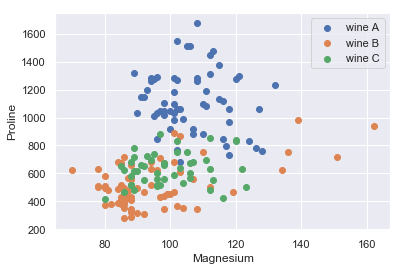

In [4]:
#X is the input matrix
#magnesium is column 4 and proline column 12 of the data matrix
X = wine.data[:, [4, 12]]

#Y is the output vector, we use newaxis of Numpy to convert the array to a column-vector
Y = wine.target[:, np.newaxis]

#we create filters to plot each target (wine) separately
#the array must be flattened to be used for slicing of X
is_A = (Y == 0).flatten()
is_B = (Y == 1).flatten()
is_C = (Y == 2).flatten()

#we plot proline VS magnesium
fig, ax = plt.subplots()
ax.scatter(X[:, 0][is_A], X[:, 1][is_A], label="wine A", color="C0")
ax.scatter(X[:, 0][is_B], X[:, 1][is_B], label="wine B", color="C1")
ax.scatter(X[:, 0][is_C], X[:, 1][is_C], label="wine C", color="C2")
ax.set_xlabel("Magnesium")
ax.set_ylabel("Proline")
ax.legend()
plt.show()

Wines B and C will be difficult to separate based on proline and magnesium, but it looks straightforward to separate wine A from wines B and C. This approach is called *one-VS-all* because we put B and C in the same class and perform classification against A.

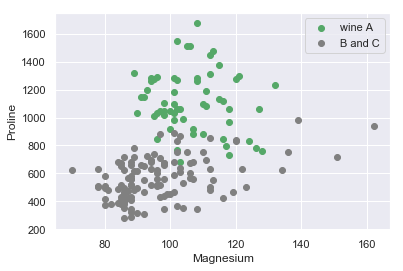

In [5]:
#new filter to put B and C wines together
is_BC = (Y != 0).flatten()

#we plot proline VS magnesium
fig, ax = plt.subplots()
ax.scatter(X[:, 0][is_A], X[:, 1][is_A], label="wine A", color="C2")
ax.scatter(X[:, 0][is_BC], X[:, 1][is_BC], label="B and C", color="gray")
ax.set_xlabel("Magnesium")
ax.set_ylabel("Proline")
ax.legend()
plt.show()

Let's perform a logistic regression by gradient descent in order to separate wine A from B and C. We first need to convert Y into a vector of 0 and 1 since we perform a binary classification (2 will have to be converted to 1). The data will be split between training and test samples. Then we create an instance of LinearRegression, before using the *fit* method to calculate theta parameters and check how well  gradient descent performs by plotting cost history.

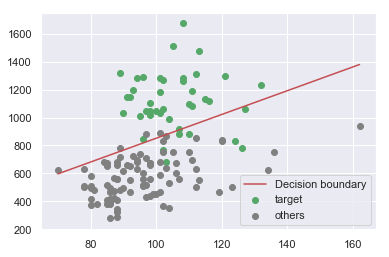

Accuracy of the model on the training sample : 0.9173


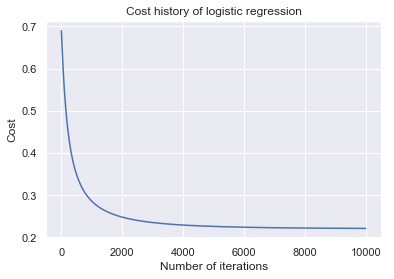

In [6]:
#convert Y so that wine A is the target, as.type converts boolean to integer (True -> 1 and False -> 0)
Y_A = (Y == 0).astype(int)

#split data between train and test samples
X_train, X_test, Y_A_train, Y_A_test = train_test_split(X, Y_A, test_size=0.25, random_state=1)

#create instance of LogisticRegression and perform logistic regression
model_1 = LogisticRegression(alpha=0.00001)
theta_1, history_1, accuracy_1 = model_1.fit(X_train, Y_A_train)

#we print the accuracy of the model on the training sample and plot the cost history
print('Accuracy of the model on the training sample :', format(accuracy_1, '.4f'))
model_1.plot_history(history_1)

The classification looks good on the graph, which is reflected by the accuracy of the model on the training sample, only a handful of data are misclassified. The cost of the logistic regression converged to a minimum, so we're satisfied. Let's calculate the accuracy of the model on the test sample to determine if the model parameters perform well on this sample.

In [7]:
accu = model_1.accuracy(X_test, Y_A_test, theta_1)
print("Accuracy of the model on the testing sample :", format(accu, '.4f'))

Accuracy of the model on the testing sample : 0.8889


## Data analysis part 2 : classification with a non-linear decision boundary
Now, let's say we are limited to a few features, and they do not allow us to do a logistic regression with a linear decision boundary, such as with *total phenols* and *color intensity*. The wines still group in distinct regions, so with a non-linear decision boundary, it should be possible to classify wine A against the others, for example.

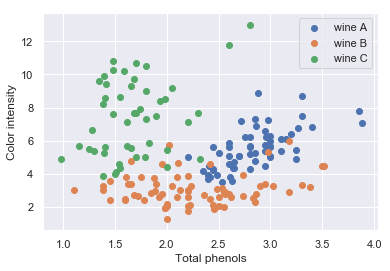

In [8]:
#total phenols is column 5 and color intensity is column 9 of the data matrix
X_2 = wine.data[:, [5, 9]]

#plot
fig, ax = plt.subplots()
ax.scatter(X_2[:, 0][is_A], X_2[:, 1][is_A], label="wine A", color="C0")
ax.scatter(X_2[:, 0][is_B], X_2[:, 1][is_B], label="wine B", color="C1")
ax.scatter(X_2[:, 0][is_C], X_2[:, 1][is_C], label="wine C", color="C2")
ax.set_xlabel("Total phenols")
ax.set_ylabel("Color intensity")
ax.legend()
plt.show()

Let's make a new model and perform logistic regression to discriminate wine A from B and C. To obtain a non-linear decision boundary we generate new features which a polynomial combinations of the two original features up to a degree of 4, using class arguments *map_feat* and *feature_degree*. To avoid overfitting, we will regularize the data with a $\lambda$ of 0.02. Finally, we will use an $\alpha$ of 0.01 and 30,000 iterations. These parameters were determined by trial and error. A frequent problem is overflow when the sigmoid function is called, because it uses an exponent. A way to solve this is to set $\lambda$ higher to reduce the impact of polyomial features(actually, all features) and use a lower degree of polynomials.

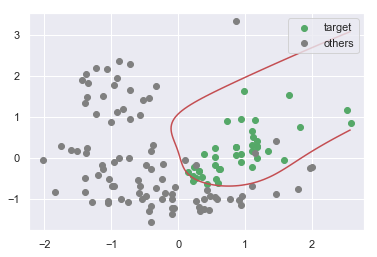

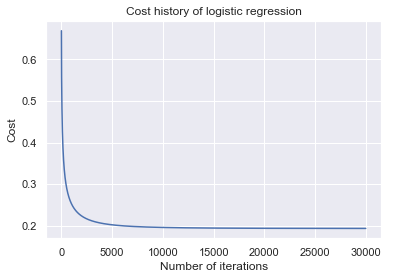

Accuracy of the model on the training sample : 0.9549
Accuracy of the model on the testing sample : 0.8222


In [9]:
#make a new model
model_2 = LogisticRegression(alpha=0.01, 
                             n_iter=30000, 
                             lamb=0.02, 
                             regularization=True, 
                             norm=True, 
                             map_feat=True, 
                             plot_boundary=True,
                             feature_degree=4)

#split data between train and test samples
X_2_train, X_2_test, Y_2_train, Y_2_test = train_test_split(X_2, Y_A, test_size=0.25, random_state=1)

#data in X_2_test need to be normalized and mapped to polynomials
X_2_test = model_2.normalize(model_2.map_feature(X_2_test))

#determine parameters of the model
theta_2, history_2, accuracy_2 = model_2.fit(X_2_train, Y_2_train)

#check that cost converges to a mimimum
model_2.plot_history(history_2)

print("Accuracy of the model on the training sample :", format(accuracy_2, '.4f'))
accu_2 = model_2.accuracy(X_2_test, Y_2_test, theta_2)
print("Accuracy of the model on the testing sample :", format(accu_2, '.4f'))